In [251]:
import nltk
from nltk.corpus import brown, gutenberg, shakespeare, wordnet, reuters
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
wordnet_lemmatizer = WordNetLemmatizer()

# Import lexicon
from nltk.corpus import words
lex = words.words('en')

In [252]:
# Prefixes of interest
prefixes_pattern = "un|non|dis|in"
prefixes = ["un", "non", "dis", "in"]

# Function to replace treebank tag with a wordnet tag to use with the Lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # Unfortunately, wordnet only supports adjective, verb, noun and adverb parts of speech
        # So, any word whose POS is not covered by wordnet will default to NOUN
        return wordnet.NOUN

def tuplize(matched_word):  
    word = matched_word[0]
    tag = matched_word[1]
    # Separate prefix from stem
    prefix = re.match(prefixes_pattern, word).group(0)
    stem = re.sub(prefix, '', word, count=1)
    lem_stem = wordnet_lemmatizer.lemmatize(stem, pos=(get_wordnet_pos(tag)))
    return (word, tag, prefix, stem, lem_stem)

In [253]:
def pre_process(corpus_words):
    # Step 1: Get all tokens that have prefixes of interest
    pattern = r'\bun\w+|\bnon\w+|\bdis\w+|\bin\w+'
    prefixed_words = list(set([w for w in corpus_words if re.match(pattern, w) and len(w) > 3]))
    
    # Step 2: Tag words
    # Words_tagged is a list of tuples containing (word, tag)
    words_tagged = nltk.pos_tag(prefixed_words)
    
    words_of_interest = [tuplize(w) for w in words_tagged]
    print("Matched words = {}".format(len(words_of_interest)))

    # Step 3: Get rid of erroneous words of interest
    # Check if stem is in the lexicon
    # If so, the prefix is negating and keep the word
    # If not, discard the word
    filtered = [w for w in words_of_interest if w[4] in lex]

    print("Matched words after filtering = {}".format(len(filtered)))
    return filtered

In [254]:
import matplotlib.pyplot as plt
%matplotlib inline

prefix_tk_freqs = dict(zip(prefixes, ([0]*len(prefixes))))
prefix_ty_freqs = dict(zip(prefixes, ([0]*len(prefixes))))

# Token frequency: Number of actual words formed according to a certain pattern over the corpus
def token_frequency(words, corpus_words):
    for c in corpus_words:
        if c in words:
            # Compute frequencies
            prefix = re.match(prefixes_pattern, c).group(0)
            prefix_tk_freqs[prefix] += 1
            
def type_frequency(filtered):
    for f in filtered:
        # Compute frequencies
        prefix = re.match(prefixes_pattern, f).group(0)
        prefix_ty_freqs[prefix] += 1

def pie_chart(type_freqs):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [pf.capitalize() + "-" for pf in type_freqs]
    sizes = [type_freqs[pf] for pf in type_freqs]
    explode = (0.1, 0, 0, 0)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
def analyze(corpus_words, filtered_words):
    corpus_size = len(corpus_words)
    filtered_size = len(filtered_words)
    token_frequency(filtered_words, corpus_words)
    type_frequency(filtered_words)

    for pf in prefix_freqs:
        prefix_tk_freqs[pf] /= corpus_size

    for pf in prefix_freqs:
        prefix_ty_freqs[pf] /= filtered_size

    for pf in prefix_freqs:
        print("Token frequency of {} = {}".format(pf, prefix_tk_freqs[pf]*100))
    print()    
    for pf in prefix_freqs:
        print("Type frequency of {} = {}".format(pf, prefix_ty_freqs[pf]*100))

    pie_chart(prefix_ty_freqs)

In [255]:
from xml.etree import ElementTree
plays = shakespeare.fileids() # doctest: +ELLIPSIS
shk_words = []
for play in plays:
    lines = [str(line.text) for line in shakespeare.xml(play).findall('ACT/SCENE/SPEECH/LINE')]
    for l in lines:
        shk_words += word_tokenize(l)

Matched words = 2315
Matched words after filtering = 1230
Token frequency of in = 0.45737483551385133
Token frequency of dis = 0.12375214434822149
Token frequency of non = 0.01687920688396062
Token frequency of un = 0.19936410171616753

Type frequency of in = 33.170731707317074
Type frequency of dis = 20.89430894308943
Type frequency of non = 4.146341463414634
Type frequency of un = 41.78861788617886


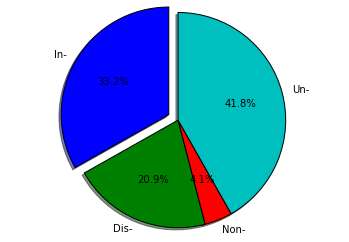

Matched words = 2533
Matched words after filtering = 1552
Token frequency of in = 0.33754045977603697
Token frequency of dis = 0.07262709017392893
Token frequency of non = 0.026739269632553273
Token frequency of un = 0.48344290303874055

Type frequency of in = 29.33838320341966
Type frequency of dis = 18.763462827927253
Type frequency of non = 0.45370253960271556
Type frequency of un = 51.5088844187411


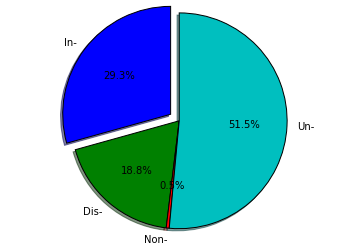

Matched words = 586
Matched words after filtering = 386
Token frequency of in = 0.18561769328300354
Token frequency of dis = 0.11312459657159692
Token frequency of non = 0.03832385277809929
Token frequency of un = 0.16345524639342787

Type frequency of in = 27.53714607047518
Type frequency of dis = 23.36467218349204
Type frequency of non = 0.5193101102062246
Type frequency of un = 48.83810591818327


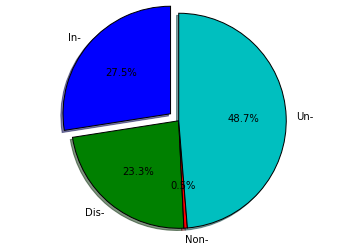

Matched words = 1163
Matched words after filtering = 558
Token frequency of in = 0.3731767170904621
Token frequency of dis = 0.10163287320107117
Token frequency of non = 0.004997404454906341
Token frequency of un = 0.17758148984470715

Type frequency of in = 34.09952893561017
Type frequency of dis = 24.952266437604827
Type frequency of non = 5.914909157903596
Type frequency of un = 35.21297151598241


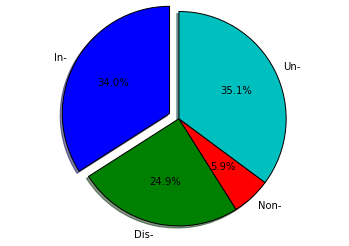

In [256]:
# Step 4: Analysis
corpora_words = [brown.words(), gutenberg.words(), shk_words, reuters.words()]

for cw in corpora_words:
    words_filtered = [f[0] for f in pre_process(cw)]
    analyze(cw, words_filtered)